Look at time-averaged fluxes through Boundary Pass
To start, use ncra (on Salish) to average the files over 40 days

In [57]:
from __future__ import division, print_function

%matplotlib inline

import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import netCDF4 as NC
import numpy as np

from salishsea_tools import viz_tools

In [67]:
U1 = NC.Dataset('/ocean/sallen/allen/research/MEOPAR/myResults/NEMO36_Tides/weaklog/SalishSea_40davg_20030421_20030510_grid_U.nc','r')
T1 = NC.Dataset('/ocean/sallen/allen/research/MEOPAR/myResults/NEMO36_Tides/weaklog/SalishSea_40davg_20030421_20030510_grid_T.nc','r')

In [128]:
print (U1.variables['vozocrtx'].shape)
uvel = U1.variables['vozocrtx'][0]
sal = T1.variables['vosaline'][0]
deptht = T1.variables['deptht'][:]
print (deptht[23])

(1, 40, 898, 398)
44.5177


In [18]:
# read the bathymetry that we specify and send into NEMO
sb_filepath = '../../NEMO-forcing/grid/bathy_meter_SalishSea2.nc'
spec_bathy = NC.Dataset(sb_filepath, 'r')
spec_depth = spec_bathy.variables['Bathymetry'][:]

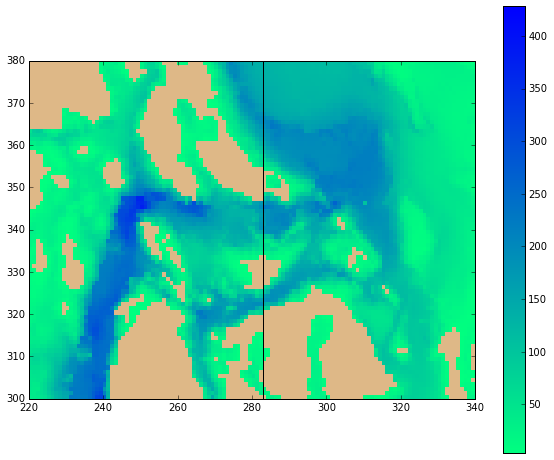

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
cmap = plt.get_cmap('winter_r')
cmap.set_bad('burlywood')
mesh = ax.pcolormesh(spec_depth, cmap=cmap)
fig.colorbar(mesh)
plt.axis((220, 340, 300, 380))
jwanted = 283; imin = 300; imax = 380
ax.plot((jwanted,jwanted),(imin,imax), 'k')

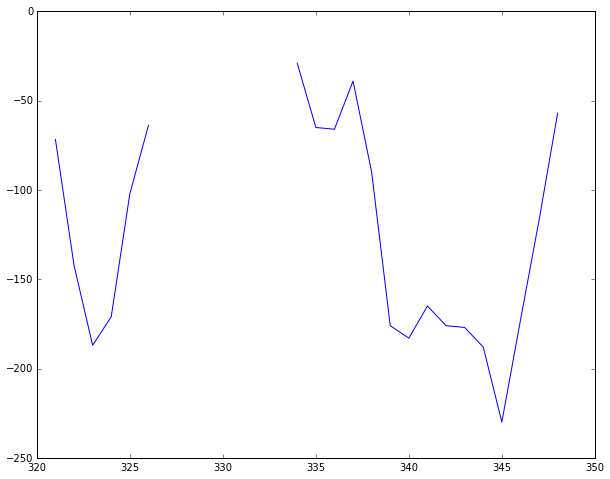

In [94]:
imin = 320; imax = 350
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(np.arange(imin,imax), -spec_depth[imin:imax,jwanted])

In [77]:
# read the bathymetry that NEMO puts out after one time step
nc_filepath = '../../NEMO-forcing/grid/grid_bathy.nc'
bathy = NC.Dataset(nc_filepath, 'r')
depth = bathy.variables['grid_bathy'][:]
dep_d = bathy.variables['deptht'][:]
lon_d = bathy.variables['nav_lon'][:]
lat_d = bathy.variables['nav_lat'][:]
print (depth.shape)

(40, 898, 398)


In [95]:
# depths are at the centre of the grid cells, find the bottom(floor) and 
# top(ceil) of the cells
floor = np.empty_like(depth[:,imin:imax,jwanted])
ceil = np.empty_like(depth[:,imin:imax,jwanted])
ceil[0] = 0.
floor[0] = 2*depth[0,imin:imax,jwanted]
for k in range(1,40):
    ceil[k] = floor[k-1]
    floor[k] = 2*depth[k,imin:imax,jwanted] -floor[k-1]
# find the actual bottom depth
bottom = np.max(floor, axis=0)
print (bottom.shape, floor.shape)

(30,) (40, 30)


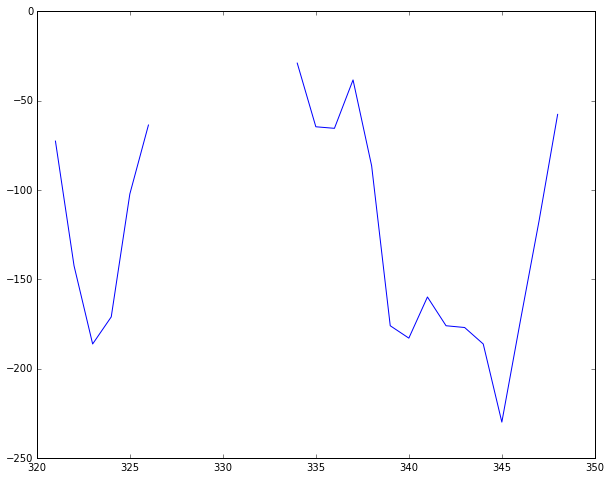

In [96]:
imin = 320; imax = 350
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(np.arange(imin,imax), - bottom[:])

29.9959275363
195.242652083 1268.90980244 -154.248570788 1381.46314836
-97.6637393069 138.657820602


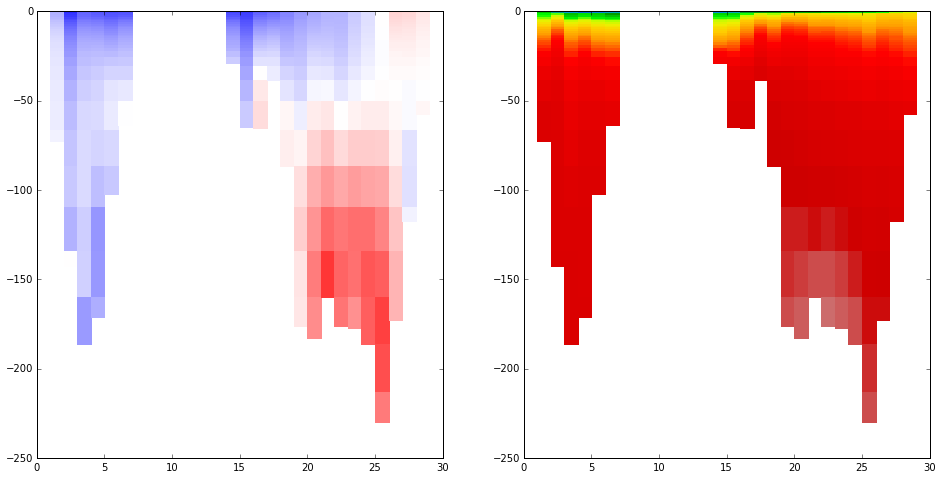

In [133]:
# plot the velocity
maxdepth = 250.
fig, ax = plt.subplots(1, 2, figsize=(16,8))
cmap = plt.get_cmap('bwr') 
cNorm  = colors.Normalize(vmin=-0.5, vmax=0.5)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)

waterfluxin = 0.
waterfluxout = 0.
weightin = 0.
weightout = 0.
surfaceflux = 0.
deepflux = 0.
for i in range(imax-imin):
    for k in range(40):
        rect = mpatches.Rectangle([i, -floor[k,i]], 1., floor[k,i]-ceil[k,i], 
                                  color=scalarMap.to_rgba(uvel[k,i+imin,jwanted]))
        if uvel[k,i+imin,jwanted] > 0:
            waterfluxin = waterfluxin + (uvel[k,i+imin,jwanted]*(floor[k,i]-ceil[k,i]))
            weightin = weightin + floor[k,i]-ceil[k,i]
        elif uvel[k,i+imin,jwanted] < 0:
            waterfluxout = waterfluxout + (uvel[k,i+imin,jwanted]*(floor[k,i]-ceil[k,i]))
            weightout = weightout + floor[k,i]-ceil[k,i]
        if uvel[k,i+imin,jwanted]*(floor[k,i]-ceil[k,i]) == uvel[k,i+imin,jwanted]*(floor[k,i]-ceil[k,i]):
            if k <= 23:
                surfaceflux = surfaceflux + (uvel[k,i+imin,jwanted]*(floor[k,i]-ceil[k,i]))
            else:
                deepflux = deepflux + (uvel[k,i+imin,jwanted]*(floor[k,i]-ceil[k,i]))
        ax[0].add_patch(rect)

ax[0].set_xlim((0,imax-imin))
ax[0].set_ylim((-maxdepth,0))

cmap = plt.get_cmap('spectral') 
cNorm  = colors.Normalize(vmin=26, vmax=30.5)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)

salaverage = 0.
depthtotal = 0.
for i in range(imax-imin):
    for k in range(40):
        rect = mpatches.Rectangle([i, -floor[k,i]], 1., floor[k,i]-ceil[k,i], 
                                  color=scalarMap.to_rgba(sal[k,i+imin,jwanted]))
        if sal[k,i+imin,jwanted]*(floor[k,i]-ceil[k,i]) == sal[k,i+imin,jwanted]*(floor[k,i]-ceil[k,i]):
            salaverage = salaverage + sal[k,i+imin,jwanted]*(floor[k,i]-ceil[k,i])
            depthtotal = depthtotal + (floor[k,i]-ceil[k,i])
        ax[1].add_patch(rect)

ax[1].set_xlim((0,imax-imin))
ax[1].set_ylim((-maxdepth,0))
salaverage = salaverage/depthtotal
print (salaverage)
print (waterfluxin, weightin, waterfluxout, weightout)
print (surfaceflux, deepflux)

50.2378053186 1268.90980244 45.5935103197 1381.46314836
0.0395913131273 0.0330037832525


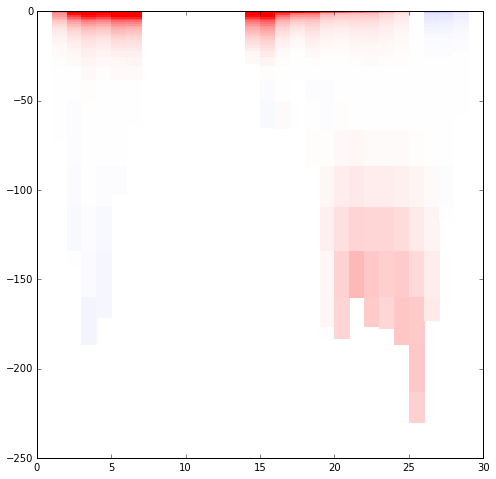

In [122]:
# plot the velocity
maxdepth = 250.
fig, ax = plt.subplots(1, 1, figsize=(8,8))
cmap = plt.get_cmap('bwr') 
cNorm  = colors.Normalize(vmin=-0.5, vmax=0.5)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)

sumfluxin = 0.
sumfluxout = 0.
weightin = 0.
weightout = 0.
for i in range(imax-imin):
    for k in range(40):
        rect = mpatches.Rectangle([i, -floor[k,i]], 1., floor[k,i]-ceil[k,i], 
                                  color=scalarMap.to_rgba(uvel[k,i+imin,jwanted]*
                                                          (sal[k,i+imin,jwanted]-salaverage)))
        if uvel[k,i+imin,jwanted] > 0:
            sumfluxin = sumfluxin + (uvel[k,i+imin,jwanted]*(sal[k,i+imin,jwanted]-salaverage)
                                     * (floor[k,i]-ceil[k,i]))
            weightin = weightin + floor[k,i]-ceil[k,i]
        elif uvel[k,i+imin,jwanted] < 0:
            sumfluxout = sumfluxout + (uvel[k,i+imin,jwanted]*(sal[k,i+imin,jwanted]-salaverage)
                                       *(floor[k,i]-ceil[k,i]))
            weightout = weightout + floor[k,i]-ceil[k,i]
        ax.add_patch(rect)

ax.set_xlim((0,imax-imin))
ax.set_ylim((-maxdepth,0))
print (sumfluxin, weightin, sumfluxout, weightout)
print (sumfluxin/weightin, sumfluxout/weightout)